<a href="https://colab.research.google.com/github/TheAmirHK/Genetic_Algorithm_Parallelization/blob/main/Codes/Parallel_Genetic_Algorithm(Mixed_Int).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

More about the parameters we need to know:<br />

**Total population size**:  The total number of individuals in the entire population across all CPUs.<br />

**Size of each subpopulation**: The number of individuals within each CPU.  The total population is divided among the CPUs.<br />

**Number of CPUs**: The number of separate subpopulations that evolve independently. CPU models help prevent premature convergence.<br />

**Number of generations**: The total number of iterations of the evolutionary algorithm.<br />

**Mutation rate**:  The probability that a random gene in an individual will be changed (mutated) during reproduction.  Higher values increase exploration.<br />

**Crossover rate**: The probability that two individuals will exchange genetic material (crossover) to create offspring. Higher values encourage combining beneficial traits.<br />

**Migrate every 5 generations**: Determines how often individuals migrate from one CPU to another. This introduces diversity and prevents CPUs from diverging too much.<br />

**Percentage of individuals to migrate**: The fraction of each subpopulation that migrates to other CPUs during a migration event.  A balance between introducing diversity and not disrupting the evolution on each CPU.

In [64]:
import random
import multiprocessing as mp
import matplotlib.pyplot as plt
from tqdm import tqdm

#In[Parameters]
POPULATION_SIZE = 1000
SUBPOPULATION_SIZE = 500
NUM_CPU = 5
GENERATIONS = 1000
MUTATION_RATE = 0.1
CROSSOVER_RATE = 0.9
MIGRATION_INTERVAL = 5
MIGRATION_RATE = 0.1

In [65]:
# In[Define optimization problem]
# minimize x1**2 + 2*x2**2 - 4*x3**2 + 11*x4**3
# s.t. x1 + x2 <= 5  and   x3^2 + x4^2 - x2*x1*x3 <= 20 and x1, x2, x3, x4 in [1, 10]
# also, x1,x2 are integer variables and x3,x4 are continues.

INTEGER_INDICES = [0, 1]
CONTINUOUS_INDICES = [2, 3]
BOUNDS = [(1, 10)]*4

def objective_function(individual):
    x1, x2, x3, x4 = individual
    return x1**2 + 2*x2**3 - 4*x3**2 + 11*x4**3

def constraint1(individual):
    x1, x2, _, _ = individual
    return x1 + x2 - 5

def constraint2(individual):
    x1, x2, x3, x4 = individual
    return (x3**2 + x4**2 - x2*x1*x3)-20

def penalty_function(individual):
    penalty = 0
    if constraint1(individual) > 0:
        penalty += 10000 * abs(constraint1(individual))
    if constraint2(individual) > 0:
        penalty += 10000 * abs(constraint2(individual))
    return penalty

def fitness_function(individual):
    return objective_function(individual) + penalty_function(individual)

In [66]:
# In[random population]

def create_individual():
    return [
        random.randint(*BOUNDS[i]) if i in INTEGER_INDICES else random.uniform(*BOUNDS[i])
        for i in range(4)
    ]

def create_subpopulation(size):
    return [create_individual() for _ in range(size)]

In [67]:
# In[selection]
def selection(population, k=3):
    tournament = random.sample(population, k)
    return min(tournament, key=fitness_function)

In [68]:
# In[crossover (single-point crossover)]
def crossover(parent1, parent2):
    if random.random() < CROSSOVER_RATE:
        point = random.randint(1, len(parent1) - 1)
        child1 = parent1[:point] + parent2[point:]
        child2 = parent2[:point] + parent1[point:]

        # Ensure integer values remain integers
        for i in INTEGER_INDICES:
            child1[i] = int(round(child1[i]))
            child2[i] = int(round(child2[i]))

        return child1, child2
    return parent1, parent2

In [69]:
# In[mutation within [1, 10]]
def mutate(individual):
    for i in range(len(individual)):
        if random.random() < MUTATION_RATE:
            if i in INTEGER_INDICES:
                individual[i] = random.randint(*BOUNDS[i])
            else:
                individual[i] += random.uniform(-0.5, 0.5)
                individual[i] = max(BOUNDS[i][0], min(BOUNDS[i][1], individual[i]))
    return individual

In [70]:
# In[Evolve the population]
def evolve_subpopulation(subpop):
    new_population = []
    while len(new_population) < len(subpop):
        parent1 = selection(subpop)
        parent2 = selection(subpop)
        child1, child2 = crossover(parent1, parent2)
        new_population.append(mutate(child1))
        new_population.append(mutate(child2))
    return new_population[:len(subpop)]

In [71]:
# In[CPU evolution process]
def CPU_evolution(CPU_id, subpop, migration_queue, generation):
    evolved_pop = evolve_subpopulation(subpop)

    # migrate individuals periodically
    if generation % MIGRATION_INTERVAL == 0:
        num_migrants = int(MIGRATION_RATE * len(evolved_pop))
        migrants = random.sample(evolved_pop, num_migrants)
        migration_queue.put((CPU_id, migrants))

    return evolved_pop

In [72]:
# In[parallel GA]
def parallel_genetic_algorithm():

    CPUs = [create_subpopulation(SUBPOPULATION_SIZE) for _ in range(NUM_CPU)]

    # create a queue for migration
    migration_queue = mp.Queue()

    # Track best fitness values for each CPU
    best_fitness_history = {i: [] for i in range(NUM_CPU)}

    for generation in tqdm(range(GENERATIONS)):

        # create processes for each CPU
        processes = []
        for CPU_id, subpop in enumerate(CPUs):
            p = mp.Process(target=CPU_evolution, args=(CPU_id, subpop, migration_queue, generation))
            processes.append(p)
            p.start()

        # wait for all CPUs
        for p in processes:
            p.join()

        # migration action form other CPUs
        while not migration_queue.empty():
            CPU_id, migrants = migration_queue.get()
            target_CPU = (CPU_id + 1) % NUM_CPU
            CPUs[target_CPU].extend(migrants)
            CPUs[target_CPU] = CPUs[target_CPU][-SUBPOPULATION_SIZE:]

        for CPU_id, subpop in enumerate(CPUs):
            best_individual = min(subpop, key=fitness_function)
            best_fitness_history[CPU_id].append(fitness_function(best_individual))

    global_best = min([min(subpop, key=fitness_function) for subpop in CPUs], key=fitness_function)
    print(f"Global Best Individual: {global_best}, Fitness: {fitness_function(global_best)}")

    plt.figure(figsize=(10, 6))
    for CPU_id, fitness_history in best_fitness_history.items():
        plt.plot(fitness_history, label=f"CPU {CPU_id+1}")
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("Evolution of Best Fitness Values Across CPUs")
    plt.legend()
    plt.grid()
    plt.show()

100%|██████████| 1000/1000 [01:37<00:00, 10.22it/s]


Global Best Individual: [3, 2, 8.291387362254088, 1], Fitness: -238.9884175637872


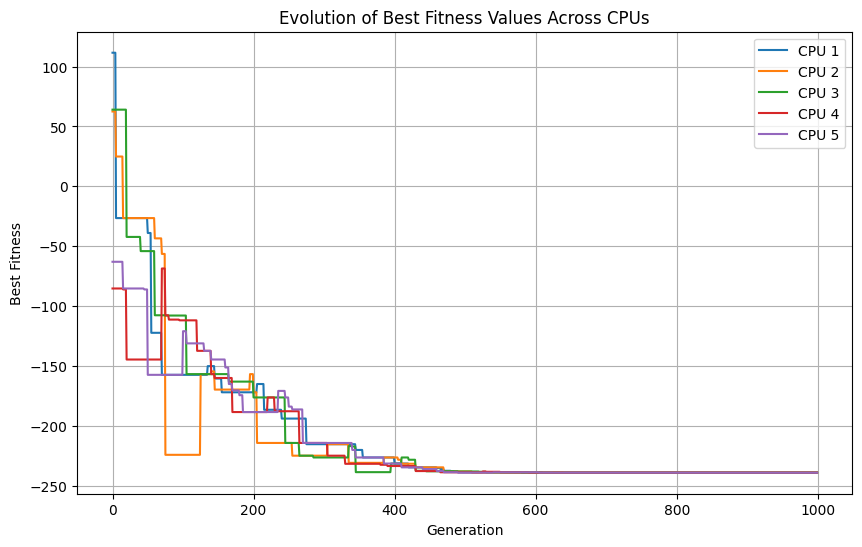

In [73]:
if __name__ == "__main__":
    parallel_genetic_algorithm()